<a href="https://colab.research.google.com/github/hez4777/gesture_recognizer/blob/main/gesture_test_march1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install required dependencies
!pip install mediapipe scikit-learn seaborn

# Step 3: Import libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from typing import List, Dict, Tuple, Optional
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 8.6 MB/s eta 0:00:00


In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from typing import List, Dict, Tuple, Optional
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [11]:
def list_gesture_folders(dataset_path: str) -> List[str]:
    """List all gesture subfolders in the dataset directory."""
    return [d for d in os.listdir(dataset_path)
            if os.path.isdir(os.path.join(dataset_path, d))]

def sample_images_from_folders(dataset_path: str, folders: List[str],
                              sample_ratio: float = 0.2) -> Dict[str, List[str]]:
    """Sample a percentage of images from each gesture folder."""
    sampled_images = {}

    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        image_paths = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                     glob.glob(os.path.join(folder_path, "*.jpeg")) + \
                     glob.glob(os.path.join(folder_path, "*.png"))

        # Sample images
        num_samples = max(1, int(len(image_paths) * sample_ratio))
        sampled = random.sample(image_paths, num_samples)
        sampled_images[folder] = sampled

        print(f"Sampled {len(sampled)} images from {folder} (total: {len(image_paths)})")

    return sampled_images

def load_gesture_recognizer(model_path: str) -> vision.GestureRecognizer:
    """Load the gesture recognizer model."""
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.GestureRecognizerOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.IMAGE,
        num_hands=1
    )
    return vision.GestureRecognizer.create_from_options(options)

def process_image(image_path: str, recognizer: vision.GestureRecognizer) -> Optional[str]:
    """
    Process a single image and return the recognized gesture.
    Returns None if no hand is detected.
    """
    try:
        # Load the image
        image = mp.Image.create_from_file(image_path)

        # Detect gestures
        recognition_result = recognizer.recognize(image)

        # Check if any hand gestures were detected
        if recognition_result.gestures and len(recognition_result.gestures) > 0:
            # Return the top gesture category
            return recognition_result.gestures[0][0].category_name
        else:
            # No gesture detected (no hand or unrecognized hand pose)
            return "None"
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return "None"

def evaluate_gesture_recognizer(dataset_path: str, model_path: str,
                              sample_ratio: float = 0.2) -> Tuple[np.ndarray, List[str], pd.DataFrame]:
    """
    Evaluate the gesture recognizer on sampled images from each gesture folder.
    Returns confusion matrix, class names, and a DataFrame with detailed results.
    """
    # List gesture folders
    gesture_folders = list_gesture_folders(dataset_path)
    print(f"Found {len(gesture_folders)} gesture classes: {gesture_folders}")

    # Sample images from each folder
    sampled_images = sample_images_from_folders(dataset_path, gesture_folders, sample_ratio)

    # Load the gesture recognizer
    recognizer = load_gesture_recognizer(model_path)

    # Process all sampled images
    true_labels = []
    predicted_labels = []
    results_data = []

    for gesture_class, image_paths in sampled_images.items():
        for image_path in image_paths:
            # True label is the folder name
            true_label = gesture_class

            # Get prediction
            predicted_label = process_image(image_path, recognizer)

            # Store results
            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            results_data.append({
                "image_path": image_path,
                "true_label": true_label,
                "predicted_label": predicted_label
            })

            print(f"Image: {os.path.basename(image_path)}, True: {true_label}, Predicted: {predicted_label}")

    # Create confusion matrix
    # Add "None" to the list of classes if it's in predictions but not in folders
    all_classes = gesture_folders.copy()
    if "None" in predicted_labels and "None" not in all_classes:
        all_classes.append("None")

    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=all_classes)

    # Create results DataFrame
    results_df = pd.DataFrame(results_data)

    return conf_matrix, all_classes, results_df

def plot_confusion_matrix(conf_matrix: np.ndarray, class_names: List[str], save_path: Optional[str] = None,
                      normalize: bool = False, precision: bool = False):
    """
    Plot and optionally save the confusion matrix.

    Args:
        conf_matrix: The confusion matrix to plot
        class_names: List of class names
        save_path: Optional path to save the figure
        normalize: Whether to normalize the matrix (to 1 or 100%)
        precision: If True, normalize by predicted (column); if False, normalize by actual (row)
    """
    plt.figure(figsize=(10, 8))

    # Create a copy of the confusion matrix
    cm_display = conf_matrix.copy().astype(float)

    # Normalize the confusion matrix if requested
    if normalize:
        if precision:
            # Normalize by column (predicted) for precision matrix
            # Avoid division by zero by adding a small epsilon where sum is zero
            col_sums = cm_display.sum(axis=0)
            col_sums[col_sums == 0] = 1e-10  # Avoid division by zero
            cm_display = cm_display / col_sums[np.newaxis, :]
            title = 'Normalized Precision Confusion Matrix'
            fmt = '.3f'
        else:
            # Normalize by row (true) for recall matrix
            row_sums = cm_display.sum(axis=1)
            row_sums[row_sums == 0] = 1e-10  # Avoid division by zero
            cm_display = cm_display / row_sums[:, np.newaxis]
            title = 'Normalized Recall Confusion Matrix'
            fmt = '.3f'
    else:
        title = 'Gesture Recognition Confusion Matrix'
        fmt = 'g'  # 'g' format works for both integers and floats

    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

    if save_path:
        # Modify the filename to indicate normalization if applied
        if normalize:
            base, ext = os.path.splitext(save_path)
            if precision:
                save_path = f"{base}_precision_norm{ext}"
            else:
                save_path = f"{base}_recall_norm{ext}"

        plt.savefig(save_path, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

In [4]:
DATASET_PATH = '/content/drive/MyDrive/gesture/gesture_data/dataset_combined'  # Path to your dataset in Google Drive
MODEL_PATH = '/content/drive/MyDrive/gesture/model/gesture_recognizer_ver2.task'  # Path to your model file
OUTPUT_DIR = '/content/drive/MyDrive/gesture/gesture_results'  # Path to save results
SAMPLE_RATIO = 0.2  # Percentage of images to sample from each class

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [5]:
conf_matrix, class_names, results_df = evaluate_gesture_recognizer(
    DATASET_PATH, MODEL_PATH, SAMPLE_RATIO
)

Streaming output truncated to the last 5000 lines.
Image: OKAY_TANK_VERTICAL_da4e7597ef_frame_000008.jpg, True: Ok, Predicted: None
Image: OKAY_TANK_VERTICAL_bf91f91164_frame_000017.jpg, True: Ok, Predicted: Ok
Image: OKAY_TANK_VERTICAL_a9f60d55f5_frame_000010.jpg, True: Ok, Predicted: Ok
Image: OKAY_TANK_VERTICAL_23d4359107_frame_000001.jpg, True: Ok, Predicted: None
Image: OKAY_TANK_VERTICAL_d43408c3bb_frame_000023.jpg, True: Ok, Predicted: None
Image: ASCEND_TANK_VERTICAL_9f0871fdb8_frame_000052.jpg, True: Ok, Predicted: None
Image: OKAY_TANK_VERTICAL_b4d98e11ef_frame_000008.jpg, True: Ok, Predicted: None
Image: OKAY_TANK_VERTICAL_bf91f91164_frame_000013.jpg, True: Ok, Predicted: Ok
Image: OKAY_TANK_VERTICAL_6d931cf2d5_frame_000048.jpg, True: Ok, Predicted: Ok
Image: OKAY_TANK_VERTICAL_efd8fe31a6_frame_000054.jpg, True: Ok, Predicted: None
Image: OK_clip_100032.jpg, True: Ok, Predicted: None
Image: OKAY_TANK_VERTICAL_41aa80bdf5_frame_000037.jpg, True: Ok, Predicted: Ok
Image: OKAY_T

Detailed results saved to /content/drive/MyDrive/gesture/gesture_results/detailed_results.csv
Confusion matrix saved to /content/drive/MyDrive/gesture/gesture_results/confusion_matrix.png


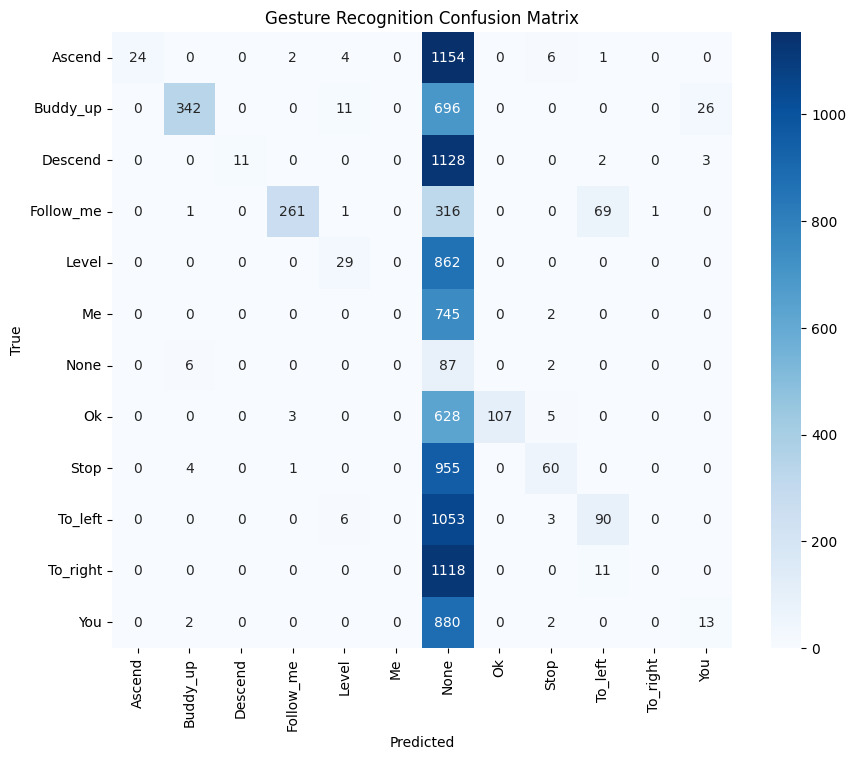

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

      Ascend       1.00      0.02      0.04      1226
    Buddy_up       0.96      0.31      0.47      1095
     Descend       1.00      0.01      0.02      1168
   Follow_me       0.98      0.30      0.45       883
       Level       0.57      0.03      0.06       891
          Me       0.00      0.00      0.00       750
        None       0.01      0.88      0.02        99
          Ok       1.00      0.14      0.25       745
        Stop       0.75      0.06      0.11      1053
     To_left       0.52      0.08      0.13      1168
    To_right       0.00      0.00      0.00      1151
         You       0.31      0.01      0.03       902

   micro avg       0.10      0.09      0.09     11131
   macro avg       0.59      0.15      0.13     11131
weighted avg       0.65      0.09      0.14     11131

Report saved to /content/drive/MyDrive/gesture/gesture_results/classification_report.txt

Overall Accuracy: 0

,image_path,true_label,predicted_label
5405,/content/drive/MyDrive/gesture/gesture_data/da...,Me,None
1488,/content/drive/MyDrive/gesture/gesture_data/da...,Buddy_up,None
1394,/content/drive/MyDrive/gesture/gesture_data/da...,Buddy_up,None
4153,/content/drive/MyDrive/gesture/gesture_data/da...,Follow_me,None
7231,/content/drive/MyDrive/gesture/gesture_data/da...,Stop,None
635,/content/drive/MyDrive/gesture/gesture_data/da...,Ascend,None
5170,/content/drive/MyDrive/gesture/gesture_data/da...,Level,None
8836,/content/drive/MyDrive/gesture/gesture_data/da...,To_left,None
5701,/content/drive/MyDrive/gesture/gesture_data/da...,Me,None
9757,/content/drive/MyDrive/gesture/gesture_data/da...,To_right,None


In [6]:
results_path = os.path.join(OUTPUT_DIR, "detailed_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Detailed results saved to {results_path}")

# Plot and save confusion matrix
cm_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plot_confusion_matrix(conf_matrix, class_names, cm_path)

# Calculate and print classification report
report = classification_report(
    results_df["true_label"],
    results_df["predicted_label"],
    labels=class_names
)

report_path = os.path.join(OUTPUT_DIR, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print("\nClassification Report:")
print(report)
print(f"Report saved to {report_path}")

# Calculate overall accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Display some example predictions
print("\nSample predictions:")
display(results_df.sample(min(10, len(results_df))))

Detailed results saved to /content/drive/MyDrive/gesture/gesture_results/detailed_results.csv
Confusion matrix saved to /content/drive/MyDrive/gesture/gesture_results/confusion_matrix.png


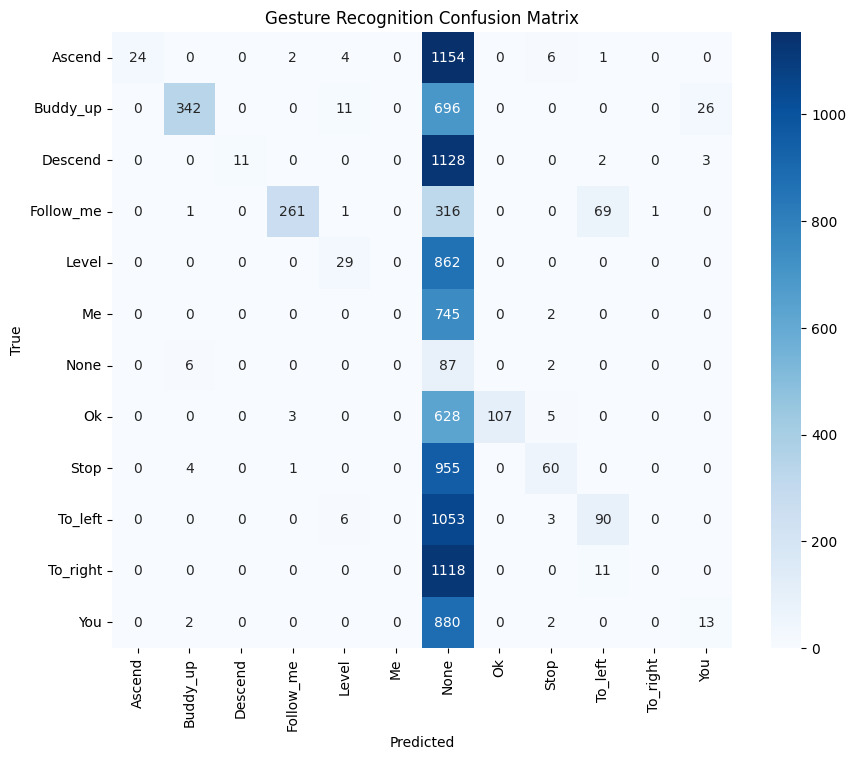

Confusion matrix saved to /content/drive/MyDrive/gesture/gesture_results/confusion_matrix_precision_norm.png


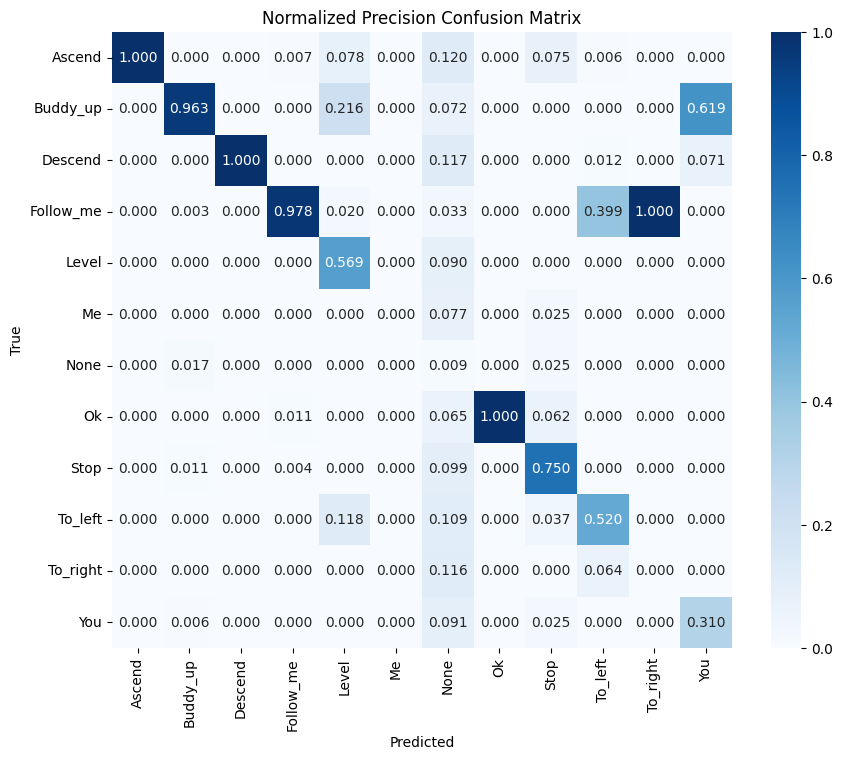

Confusion matrix saved to /content/drive/MyDrive/gesture/gesture_results/confusion_matrix_recall_norm.png


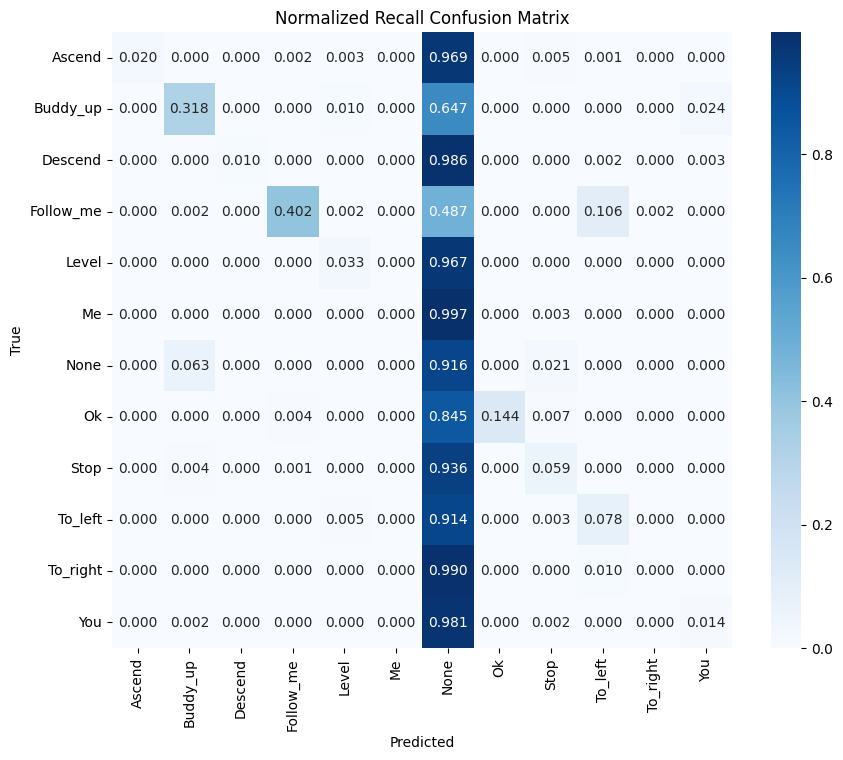


Classification Report:
              precision    recall  f1-score   support

      Ascend       1.00      0.02      0.04      1226
    Buddy_up       0.96      0.31      0.47      1095
     Descend       1.00      0.01      0.02      1168
   Follow_me       0.98      0.30      0.45       883
       Level       0.57      0.03      0.06       891
          Me       0.00      0.00      0.00       750
        None       0.01      0.88      0.02        99
          Ok       1.00      0.14      0.25       745
        Stop       0.75      0.06      0.11      1053
     To_left       0.52      0.08      0.13      1168
    To_right       0.00      0.00      0.00      1151
         You       0.31      0.01      0.03       902

   micro avg       0.10      0.09      0.09     11131
   macro avg       0.59      0.15      0.13     11131
weighted avg       0.65      0.09      0.14     11131

Report saved to /content/drive/MyDrive/gesture/gesture_results/classification_report.txt

Overall Accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,image_path,true_label,predicted_label
448,/content/drive/MyDrive/gesture/gesture_data/da...,Ascend,None
5090,/content/drive/MyDrive/gesture/gesture_data/da...,Level,None
10823,/content/drive/MyDrive/gesture/gesture_data/da...,You,None
9437,/content/drive/MyDrive/gesture/gesture_data/da...,To_right,To_left
5235,/content/drive/MyDrive/gesture/gesture_data/da...,Level,None
6340,/content/drive/MyDrive/gesture/gesture_data/da...,Ok,None
6857,/content/drive/MyDrive/gesture/gesture_data/da...,Stop,Stop
1787,/content/drive/MyDrive/gesture/gesture_data/da...,Buddy_up,
5753,/content/drive/MyDrive/gesture/gesture_data/da...,Me,None
2712,/content/drive/MyDrive/gesture/gesture_data/da...,Descend,None


In [12]:
results_path = os.path.join(OUTPUT_DIR, "detailed_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Detailed results saved to {results_path}")

# Plot and save confusion matrices
cm_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
# Standard confusion matrix
plot_confusion_matrix(conf_matrix, class_names, cm_path)

# Normalized precision confusion matrix (normalized by column)
plot_confusion_matrix(conf_matrix, class_names, cm_path, normalize=True, precision=True)

# Normalized recall confusion matrix (normalized by row)
plot_confusion_matrix(conf_matrix, class_names, cm_path, normalize=True, precision=False)

# Calculate and print classification report
report = classification_report(
    results_df["true_label"],
    results_df["predicted_label"],
    labels=class_names
)

report_path = os.path.join(OUTPUT_DIR, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print("\nClassification Report:")
print(report)
print(f"Report saved to {report_path}")

# Calculate overall accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Display some example predictions
print("\nSample predictions:")
display(results_df.sample(min(10, len(results_df))))